# Six Southern Labor Markets #1
### Age and family structure

February 1, 2019

Brian Dew, @bd_econ

-----

Look at share of population under 16, over 64, age 25-30 married, age 25-30 with one kid, age 25-30 with more than 2 kids, for:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- Total
- Other south
- Other US

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
os.environ['PROJ_LIB'] = '/home/brian/miniconda3/share/proj'
import shapefile
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

os.chdir('shapefiles')

In [2]:
areas = [('Chattanooga-\nCleveland-\nDalton, TN-GA', 'GTCSA', [174]),
         ('Greenville-\nAnderson-\nSpartanburg, SC', 'GTCSA', [273]),
         ('Asheville, NC', 'GTCBSA', [11700]),
         ('Johnson City-\nKingsport-\nBristol, TN-VA', 'GTCSA', [304]),
         ('Huntsville, AL', 'GTCBSA', [26620]),
         ('Knoxville, TN', 'GTCBSA', [28940])]

area_names = [area[0] for area in areas]

### Create a small map showing the locations of interest

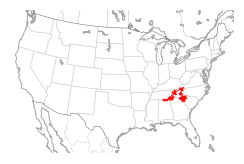

In [3]:
# Small map showing areas of interest
fig = plt.figure(figsize=(4,3))

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95, resolution='l')

m.drawcoastlines(color='darkgray')
m.drawmapboundary(linewidth=0)
m.drawstates(color='lightgray')
m.drawcountries(color='dimgray')

m.readshapefile('cb_2016_us_csa_500k', 'csa', 
                drawbounds=False, color='grey')
m.readshapefile('cb_2016_us_cbsa_500k', 'msa', 
                drawbounds=False, color='grey')

ax = plt.gca()

patches = []
for info, shape in zip(m.csa_info, m.csa):
    if info['NAME'] in ['Johnson City-Kingsport-Bristol, TN-VA', 
                        'Chattanooga-Cleveland-Dalton, TN-GA-AL',
                        'Greenville-Spartanburg-Anderson, SC']:
        patches.append(Polygon(np.array(shape), True))
        
ax.add_collection(PatchCollection(patches, facecolor='red', edgecolor='none', alpha=0.95, zorder=2))

patches = []
for info, shape in zip(m.msa_info, m.msa):
    if info['NAME'] in area_names:
        patches.append(Polygon(np.array(shape), True))
        
ax.add_collection(PatchCollection(patches, facecolor='red', edgecolor='none', alpha=0.95, zorder=2))

plt.savefig('small_map.png', bbox_inches='tight')

plt.show()

### Labor market data

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/')

# Mapping of states to Census region
cpsdd = pickle.load(open('cps_basic_dd.pkl', 'rb'))
regions_map = cpsdd['January_2017_Record_Layout.txt']['map']['region']

os.chdir('clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'GTCBSA', 'GTCSA', 'AGE', 'STATE',
           'PRNMCHLD', 'MARRIED', 'PWSSWGT']

In [5]:
df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2017, 2018]])

df['REGION'] = df['STATE'].map(regions_map).astype('category')

In [6]:
csa = [area[2][0] for area in areas if area[1] == 'GTCSA']
cbsa = [area[2][0] for area in areas if area[1] == 'GTCBSA']
grps = [('Six areas combined', 'GTCSA in @csa or GTCBSA in @cbsa'),
        ('Other south', 'REGION == "South" and GTCSA not in @csa and GTCBSA not in @cbsa'),
        ('Other US', 'GTCSA not in @csa and GTCBSA not in @cbsa'),
        ('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

In [7]:
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    results.at[group[0], 'Population'] = data.PWSSWGT.sum() / 24.0
    u16sh = data.query('AGE < 16').PWSSWGT.sum() / data.PWSSWGT.sum()
    results.at[group[0], 'Under 16 share'] = u16sh
    o64sh = data.query('AGE > 64').PWSSWGT.sum() / data.PWSSWGT.sum()
    results.at[group[0], 'Over 64 share'] = o64sh
    data = data.query('22 <= AGE <= 32')
    results.at[group[0], 'Age 22 to 32 obs.'] = len(data)
    married = data.query('MARRIED == 1').PWSSWGT.sum() / data.PWSSWGT.sum()
    results.at[group[0], 'Married share'] = married
    onekid = data.query('PRNMCHLD > 0').PWSSWGT.sum() / data.PWSSWGT.sum()
    twokids = data.query('PRNMCHLD > 1').PWSSWGT.sum() / data.PWSSWGT.sum()
    results.at[group[0], 'One or more kids'] = onekid
    results.at[group[0], 'Two or more kids'] = twokids

In [8]:
results

,Population,Under 16 share,Over 64 share,Age 22 to 32 obs.,Married share,One or more kids,Two or more kids
"Chattanooga-\nCleveland-\nDalton, TN-GA",8.023924e+05,0.187501,0.159475,949.0,0.393972,0.340596,0.200565
"Greenville-\nAnderson-\nSpartanburg, SC",1.269738e+06,0.207309,0.153858,1358.0,0.331327,0.304334,0.192544
"Asheville, NC",4.628310e+05,0.150702,0.221417,356.0,0.309849,0.247128,0.176299
"Johnson City-\nKingsport-\nBristol, TN-VA",5.049861e+05,0.193748,0.209627,609.0,0.408061,0.419380,0.200124
"Huntsville, AL",4.775807e+05,0.201037,0.113481,893.0,0.335630,0.229054,0.087132
"Knoxville, TN",8.530647e+05,0.180497,0.180724,1048.0,0.396544,0.346909,0.170724
Six areas combined,4.370593e+06,0.190192,0.169319,5213.0,0.365200,0.319647,0.175783
Other south,1.175448e+08,0.207788,0.155285,145051.0,0.339884,0.324813,0.180512
Other US,3.171723e+08,0.202656,0.156497,400587.0,0.319104,0.292420,0.161635
US Total,3.215428e+08,0.202486,0.156672,405800.0,0.319716,0.292781,0.161823


### Population

In [9]:
round(results['Population'] / 1_000)

Chattanooga-\nCleveland-\nDalton, TN-GA         802.0
Greenville-\nAnderson-\nSpartanburg, SC        1270.0
Asheville, NC                                   463.0
Johnson City-\nKingsport-\nBristol, TN-VA       505.0
Huntsville, AL                                  478.0
Knoxville, TN                                   853.0
Six areas combined                             4371.0
Other south                                  117545.0
Other US                                     317172.0
US Total                                     321543.0
Name: Population, dtype: float64

### Age composition

In [10]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

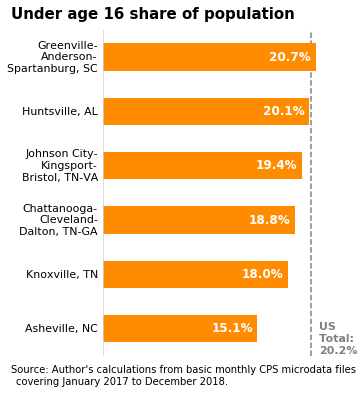

In [11]:
# Bar chart showing under 16 share of population
d = (results.loc[[g[0] for g in grps2], 'Under 16 share']
              .sort_values() * 100.0)

d_us = results.loc['US Total', 'Under 16 share'] * 100.0

d.plot(kind='barh', color='darkorange', figsize=[4, 6], width=0.5, zorder=2)
for i, val in enumerate(d):
    x_val = val - 4.5
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-0.5, i, d.index[i], ha='right', va='center', fontsize=11)

plt.axvline(x=d_us, color='gray', linestyle='--', zorder=1)
plt.text(d_us * 1.04, -0.45, f"US\nTotal:\n{round(d_us, 1)}%", 
         fontsize=11, color='gray', weight='bold')
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-9, 5.7, 'Under age 16 share of population', 
          fontsize=15, weight='bold')

plt.text(-9, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-8.5, -1.03, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('under_16_share.png', bbox_inches='tight');

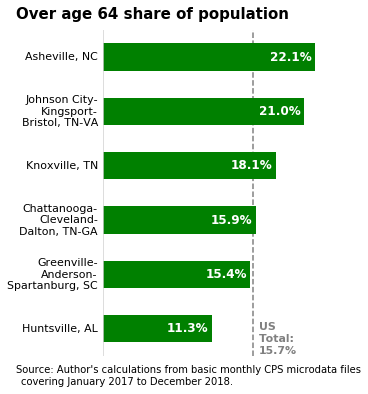

In [12]:
# Bar chart showing under 16 share of population
d = (results.loc[[g[0] for g in grps2], 'Over 64 share']
              .sort_values() * 100.0)

d_us = results.loc['US Total', 'Over 64 share'] * 100.0

d.plot(kind='barh', color='green', figsize=[4, 6], width=0.5, zorder=2)
for i, val in enumerate(d):
    x_val = val - 4.7
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-0.5, i, d.index[i], ha='right', va='center', fontsize=11)

plt.axvline(x=d_us, color='gray', linestyle='--', zorder=1)
plt.text(d_us * 1.04, -0.45, f"US\nTotal:\n{round(d_us, 1)}%", 
         fontsize=11, color='gray', weight='bold')
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-9, 5.7, 'Over age 64 share of population', 
          fontsize=15, weight='bold')

plt.text(-9, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-8.5, -1.03, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('over_64_share.png', bbox_inches='tight');

### Marriage rates for those 22-32

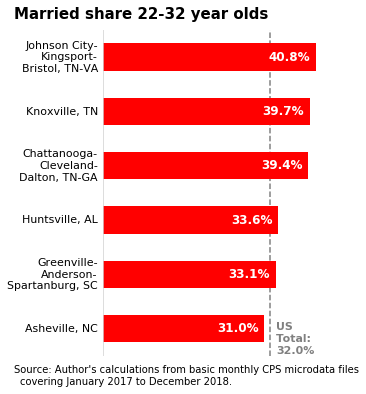

In [13]:
# Bar chart showing under 16 share of population
d = (results.loc[[g[0] for g in grps2], 'Married share']
              .sort_values() * 100.0)

d_us = results.loc['US Total', 'Married share'] * 100.0

d.plot(kind='barh', color='red', figsize=[4, 6], width=0.5, zorder=2)
for i, val in enumerate(d):
    x_val = val - 9
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-1, i, d.index[i], ha='right', va='center', fontsize=11)

plt.axvline(x=d_us, color='gray', linestyle='--', zorder=1)
plt.text(d_us * 1.04, -0.45, f"US\nTotal:\n{round(d_us, 1)}%", 
         fontsize=11, color='gray', weight='bold')
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-17, 5.7, 'Married share 22-32 year olds', 
          fontsize=15, weight='bold')

plt.text(-17, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-16, -1.03, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('married_share.png', bbox_inches='tight');

### Share of age 22-32 year olds with kids

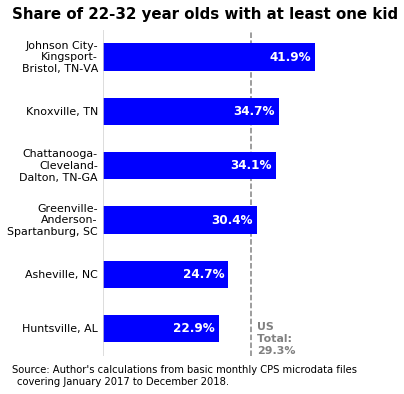

In [14]:
# Bar chart showing under 16 share of population
d = (results.loc[[g[0] for g in grps2], 'One or more kids']
              .sort_values() * 100.0)

d_us = results.loc['US Total', 'One or more kids'] * 100.0

d.plot(kind='barh', color='blue', figsize=[4, 6], width=0.5, zorder=2)
for i, val in enumerate(d):
    x_val = val - 9
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-1, i, d.index[i], ha='right', va='center', fontsize=11)

plt.axvline(x=d_us, color='gray', linestyle='--', zorder=1)
plt.text(d_us * 1.04, -0.45, f"US\nTotal:\n{round(d_us, 1)}%", 
         fontsize=11, color='gray', weight='bold')
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-18, 5.7, 'Share of 22-32 year olds with at least one kid', 
          fontsize=15, weight='bold')

plt.text(-18, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-17, -1.03, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('one_or_more_kids.png', bbox_inches='tight');

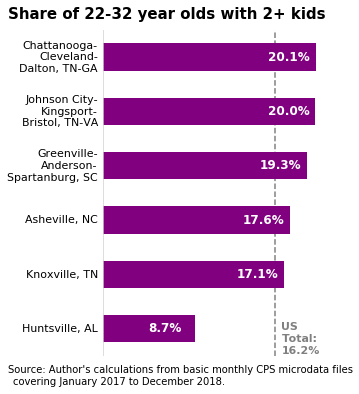

In [15]:
# Bar chart showing under 16 share of population
d = (results.loc[[g[0] for g in grps2], 'Two or more kids']
              .sort_values() * 100.0)

d_us = results.loc['US Total', 'Two or more kids'] * 100.0

d.plot(kind='barh', color='purple', figsize=[4, 6], width=0.5, zorder=2)
for i, val in enumerate(d):
    x_val = val - 4.5
    text_val = f'{round(val, 1)}%'
    y_val = i - 0.06
    plt.text(x_val, y_val, text_val, color='white', fontsize=12, weight='bold')
    plt.text(-0.5, i, d.index[i], ha='right', va='center', fontsize=11)

plt.axvline(x=d_us, color='gray', linestyle='--', zorder=1)
plt.text(d_us * 1.04, -0.45, f"US\nTotal:\n{round(d_us, 1)}%", 
         fontsize=11, color='gray', weight='bold')
    
plt.axvline(x=0, color='lightgray')    

# add title and footer
plt.text(-9, 5.7, 'Share of 22-32 year olds with 2+ kids', 
          fontsize=15, weight='bold')

plt.text(-9, -0.8, "Source: Author's calculations from basic monthly CPS microdata files")
plt.text(-8.5, -1.03, 'covering January 2017 to December 2018.')

plt.axis('off')

plt.savefig('two_or_more_kids.png', bbox_inches='tight');